## Performance Tests

This Notebook test performance of different implementations of SNT-Python data type conversions. The Context is computing the convex hull of nodes in a neuronal reconstruction (in this case idealized as a sphere for stress testing purposes).

In [1]:
import ijfinder
import imagej
import os
import timeit
import imagej
import numpy as np
from scipy.spatial import ConvexHull

fiji_path = ijfinder.getpath().decode('utf-8')
if os.path.isdir(fiji_path):
    ij = imagej.init(fiji_path, mode='interactive')
else:
    print("Cannot proceed: Fiji not found!")

In [2]:
from scyjava import jimport
# Import relevant Java classes
HashSet = jimport('java.util.HashSet')
PointInImage = jimport('sc.fiji.snt.util.PointInImage')
MouseLightLoader = jimport('sc.fiji.snt.io.MouseLightLoader')
Tree = jimport('sc.fiji.snt.Tree')
TreeStatistics = jimport('sc.fiji.snt.analysis.TreeStatistics')
Color = jimport('org.scijava.util.Colors')
Viewer = jimport('sc.fiji.snt.viewer.Viewer3D')

In [3]:
import math, random

def fibonacci_sphere(samples=100, randomize=False):
    """Test code to generate convex hull where number of samples == number of hull vertices.
    Assumes that a convex hull of a uniformly distributed spherical point cloud 
    will have outer vertices comprised of all samples that compose the cloud."""
    
    rnd = 1.
    if randomize:
        rnd = random.random() * samples

    points = []
    offset = 2./samples
    increment = math.pi * (3. - math.sqrt(5.));

    for i in range(samples):
        y = ((i * offset) - 1) + (offset / 2);
        r = math.sqrt(1 - pow(y,2))

        phi = ((i + rnd) % samples) * increment

        x = math.cos(phi) * r
        z = math.sin(phi) * r

        points.append([x,y,z])

    return points

In [4]:
def run_original(tree):
    """This version creates a new PointInImage object for each computed vertex 
    and adds it to an empty HashSet."""
    
    points = ij.py.to_java(tree)
    points_iterator = points.iterator()

    # Convert to Python list.
    points_list = []
    while points_iterator.hasNext():
        n = points_iterator.next()
        points_list.append([n[0], n[1], n[2]])

    # Find the convex hull of the input points.
    X = np.asarray(points_list)
    
    hull = ConvexHull(X)
    verts = X[hull.vertices]

    # Construct new Java Hashset containing the hull vertices.
    verts_java = HashSet()
    for v in verts:
        verts_java.add(PointInImage(v[0], v[1], v[2]))  

In [5]:
def run_indexing(tree):
    """This version relies on keeping an ordered array of the input points,
    and uses the computed hull vertices to find the associated SNTPoint objects
    by indexing into the original Java array. Bypasses re-constructing a 
    sc.fiji.snt.util.PointInImage object for each hull vertex."""
    
    points = ij.py.to_java(tree)
    points_java_array = points.toArray()
    
    # Convert to Python list.
    points_list = [[t[0], t[1], t[2]] for t in points_java_array]

    # Find the convex hull of the input points.
    hull = ConvexHull(points_list)
    # Find the original PointInImage objects and convert to Java array.
    verts_java = [points_java_array[i] for i in hull.vertices]
    verts_java = ij.py.to_java(verts_java)
    

In [6]:
# magic %timeit does not work with functions using arguments, use timeit.timeit and wrapper function instead
def timeit_wrapper(func, *args, **kwargs):
    
    def wrapped():
        
        return func(*args, **kwargs)
    
    return wrapped


In [7]:
def measure_scaling(function, ex):
    """Function to measure how performance scales with number of hull vertices
    to compare different ways of converting between Python and Java data types."""
    
    X = []
    Y = []
    
    for i in range(1,ex+1):
        samples = 10**i
        tree = fibonacci_sphere(samples, randomize=False)
        wrapped = timeit_wrapper(function, tree)
        x = samples
        X.append(x)
        y = timeit.timeit(wrapped, number=1)
        Y.append(y)
        
    return X, Y


In [8]:
# Test with 10^5 hull vertices.
X_original, Y_original = measure_scaling(run_original, 5)
X_indexing, Y_indexing = measure_scaling(run_indexing, 5)


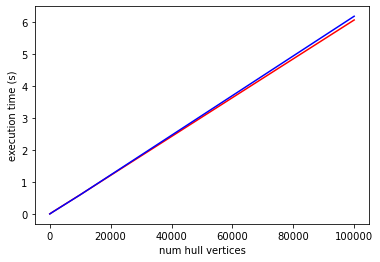

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(X_original, Y_original, 'r')
plt.plot(X_indexing, Y_indexing, 'b')
plt.xlabel('num hull vertices')
plt.ylabel('execution time (s)')
plt.show()
